# 4. Task

The purpose of this task is to implement an image-based closed control loop. The controller must be in a separate module. The robot and feature extraction could be together in another module 
or in separate modules.

In [1]:
# First we import all the packages needed.
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


An image-based closed control loop refers to a control system where feedback is provided through images or visual data. It involves capturing images of a process or environment, analyzing these images to extract relevant information, and using this information to adjust and control the system. This approach allows for precise and dynamic control in applications such as robotics, industrial automation, and surveillance. In the next image we can see a scheme of the system. 

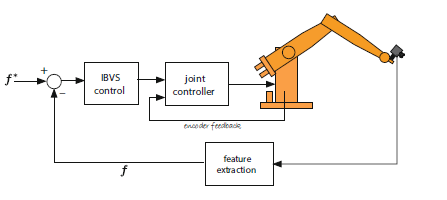

It should be noted that, unlike the PBVS, the IBVS omits the pose estimation
step, and uses the image features directly. Also, the desired camera pose with respect to the goal is defined implicitly by the desired image feature values. IBVS is a challenging control problem since the image features are a highly nonlinear function of camera pose.

Here we define the IBVS_Actuator class, which is a subclass of VisualServo. 

In [2]:
class IBVS_Actuator(VisualServo):
    def __init__(self, camera, lmbda=0.05):
        self.camera = camera
        self.lmbda = lmbda

    def actuate(self, velocity):
        self.Td = SE3.Delta(velocity)
        self.camera.pose @= self.Td

The next class defines the feature extractor module, which is used to extract the features from the image plane.

In [3]:
class IBVS_Featurextractor(VisualServo):
    def __init__(self, camera, P, p_star=None):
        self.camera = camera
        self.P = P
        self.p_star = p_star

    def compute_current_view(self):
        uv = self.camera.project_point(self.P)
        return uv
    def depth_estimator(self, uv, uv_prev, vel_prev):
    # test if first frame
        if self.uv_prev is None:
            Z_est = None

        else:
            # compute Jacobian for unit depth, z=1
            J = self.camera.visjac_p(uv, 1)
            Jv = J[:, :3]  # velocity part, depends on 1/z
            Jw = J[:, 3:]  # rotational part, indepedent of 1/z

            # estimate image plane velocity
            uv_d = uv.flatten(order="F") - self.uv_prev.flatten(order="F")

            # estimate coefficients for A (1/z) = b
            b = uv_d - Jw @ self.vel_prev[3:]
            A = Jv @ self.vel_prev[:3]

            AA = np.zeros((A.shape[0], A.shape[0] // 2))
            for i in range(A.shape[0] // 2):
                AA[2 * i : (i + 1) * 2, i] = A[2 * i : (i + 1) * 2]

            eta, resid, *_ = np.linalg.lstsq(
                AA, b.ravel(), rcond=None
            )  # least squares solution
            # eta2 = A(1:2) \ B(1:2)

            # first order smoothing
            self.theta = (1 - self.smoothing) * 1 / eta + self.smoothing * self.theta
            Z_est = self.theta

        # true depth
        P_CT = self.camera.pose.inv() * self.P
        Z_true = P_CT[2, :]

        if self.verbose:
            print("depth", Z_true)
            print("est depth", Z_est)

        return Z_est, Z_true

The next cell defines the controller module of the IBVS system.  This controller works by computing the image plane velocity that minimizes the error between the current image plane coordinates and the desired image plane coordinates.

In [4]:
class IBVS_Controller(VisualServo):
    def __init__(self, camera, eterm=0, lmbda=0.05):
        self.eterm = eterm
        self.lmbda = lmbda
        self.camera = camera

    def compute_velocity(self, uv, p_star):
        self.e = uv - p_star
        self.e = self.e.flatten(order="F")
        self.J = self.camera.visjac_p(uv, 1)  # Assuming depth is 1 for simplicity
        try:
            v = -self.lmbda * np.linalg.pinv(self.J) @ self.e
        except np.linalg.LinAlgError:
            return None
        return v

Here, we define a IBVS_System class to implement the IBVS closed control algorithm. 

In [5]:
class IBVS_System(VisualServo):
    def __init__(
        self,
        camera,
        eterm=0.5,
        lmbda=0.08,
        depth=None,
        depthest=False,
        vmax=None,
        smoothstart=None,
        **kwargs,
    ):
        super().__init__(camera, type="point", title="IBVS simulation", **kwargs)


        self.actuator = IBVS_Actuator(camera, lmbda)
        self.feature_extractor = IBVS_Featurextractor(camera, self.P, self.p_star)
        self.controller = IBVS_Controller(camera, eterm, lmbda)

        self.depth = depth
        self.depthest = depthest
        self.vmax = vmax
        self.smoothstart = smoothstart

    def step(self, t):
        status = 0
        uv = self.feature_extractor.compute_current_view()
        hist = self._history()

        if self.depthest:
            Z_est, Z_true = self.depth_estimator(uv)
            self.depth = Z_est

        v = self.controller.compute_velocity(uv, self.feature_extractor.p_star)

        if v is None:
            return -1

        if self.vmax is not None:
            if np.linalg.norm(v) > self.vmax:
                v = smbase.unitvec(v) * self.vmax

        self.actuator.actuate(v)
        
        # update the history variables
        hist.p = uv
        vel = self.actuator.Td.delta()
        hist.vel = vel
        hist.e = self.controller.e
        hist.enorm = np.linalg.norm(self.controller.e)
        hist.jcond = np.linalg.cond(self.controller.J)
        hist.pose = self.camera.pose

        self.history.append(hist)


        return status

In [6]:
# Goal Object
P = mkgrid(2, side=0.5, pose=SE3.Tz(3));

# desired pose
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -2));
pd = 200 * np.array([[-1, -1, 1, 1], [-1, 1, 1, -1]]) + np.c_[camera.pp]

# Defining the camera with default intrinsic parameters.
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -3) * SE3.Rz(0.6));


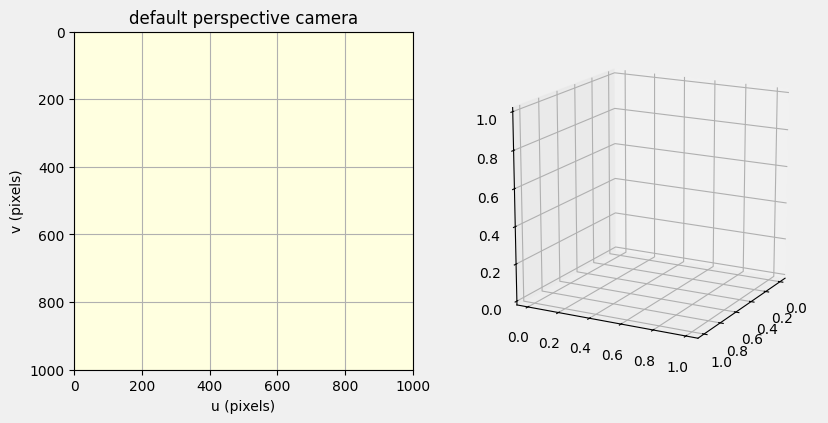

In [7]:
ibvs = IBVS_System(camera, P=P, p_d=pd)

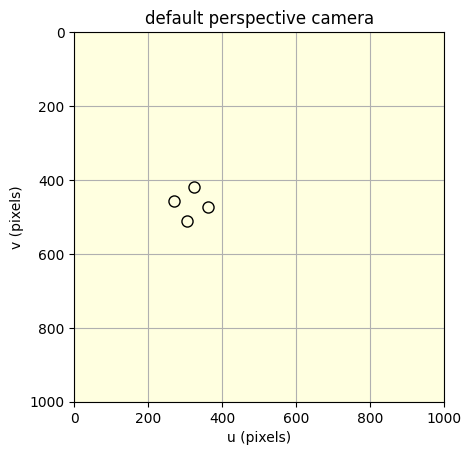

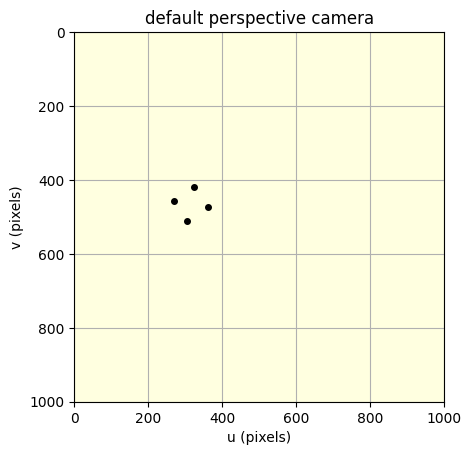

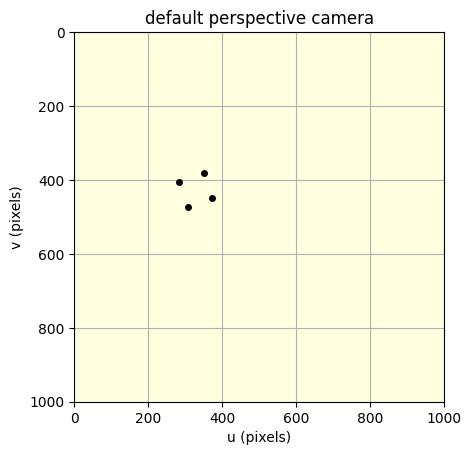

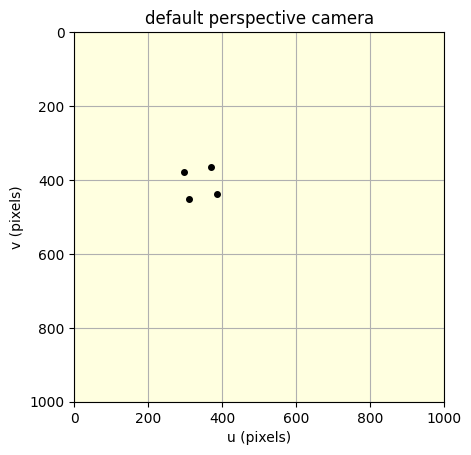

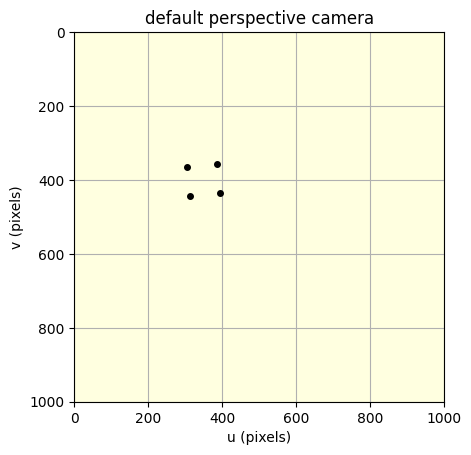

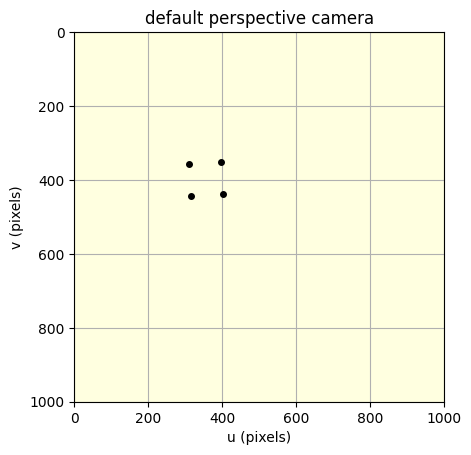

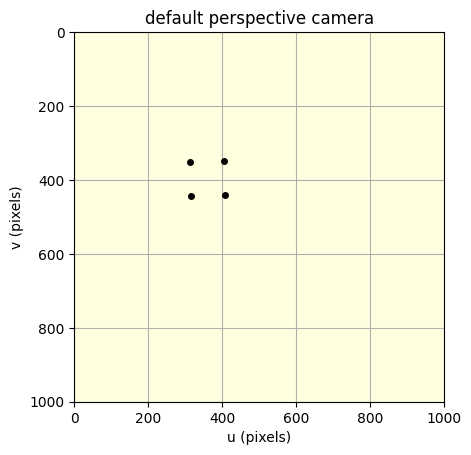

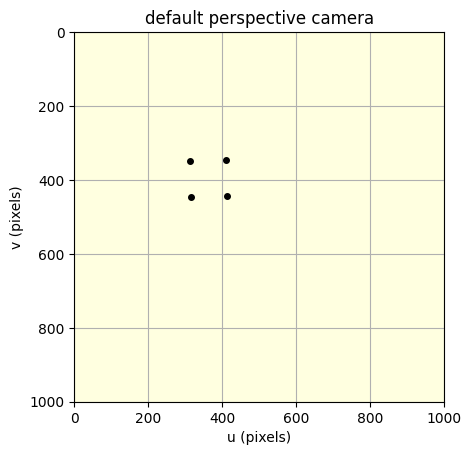

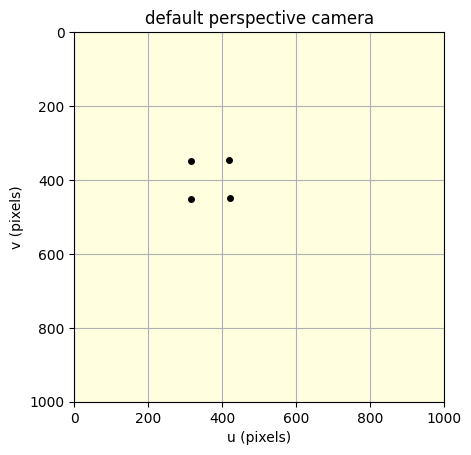

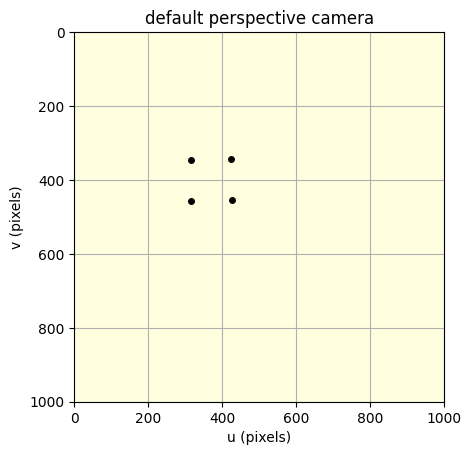

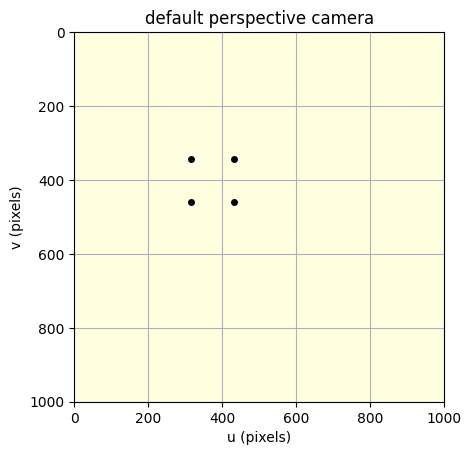

completed on iteration count


In [8]:
# Run the code
ibvs.run(10)